# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [5]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

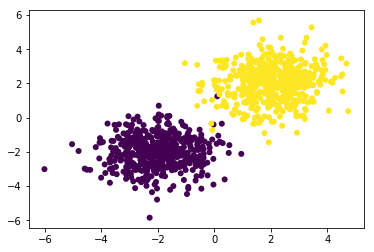

In [37]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [44]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 32

In [11]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [41]:
from tqdm import trange

def train_net(net, X_train, y_train, X_val, y_val, criterion,
              n_epoch=20, batch_size=64, lr=0.01, momentum=0.9):
    train_loss_history = []
    val_loss_history = []
    optimizer_config={'learning_rate' : lr, 'momentum': momentum}
    optimizer_state = {}


    for i in trange(n_epoch):
        net.train()
        
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
        
        loss = compute_score(net, X_train, y_train, criterion=criterion)[0]
        train_loss_history.append(loss)
        
        loss = compute_score(net, X_val, y_val, criterion=criterion)[0]
        val_loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#epoch")
        plt.ylabel("loss")
        plt.plot(np.arange(1, len(train_loss_history) + 1), train_loss_history, 'b', label='train')
        plt.plot(np.arange(1, len(val_loss_history) + 1), val_loss_history, 'r', label='val')
        plt.legend()
        plt.show()

        print('Current loss: %f' % loss) 
    
    return train_loss_history, val_loss_history

def compute_score(net, X, y, criterion, batch_size=512):
    net.evaluate()
    loss = 0.
    acc = 0.
    
    for x_batch, y_batch in get_batches((X, y), batch_size):
        predictions = net.forward(x_batch)
        loss += criterion.forward(predictions, y_batch) * len(x_batch) / len(X)
        acc += np.sum(np.argmax(y_batch, axis=1) == np.argmax(predictions, axis=1)) / len(X)
    
    return loss, acc

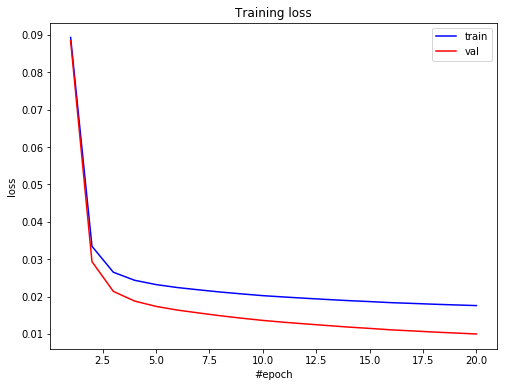

100%|██████████| 20/20 [00:04<00:00,  4.70it/s]

Current loss: 0.009986


In [45]:
train_net(net, X[:800], Y[:800], X[800:], Y[800:], criterion=criterion)
_ = _

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [13]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [14]:
y_one_hot = np.zeros((len(y), 10), dtype=int)
y_one_hot[np.arange(len(y)), y.astype(int)] = 1
y = y_one_hot

In [15]:
indices = np.arange(len(X))
np.random.seed(42)
np.random.shuffle(indices)
X_train, X_val, X_test = X[indices[:50000]], X[indices[50000:60000]], X[indices[60000:]]
y_train, y_val, y_test = y[indices[:50000]], y[indices[50000:60000]], y[indices[60000:]]


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

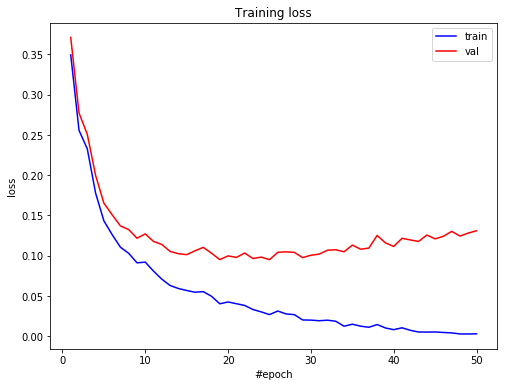

100%|██████████| 50/50 [05:10<00:00,  6.20s/it]

Current loss: 0.131055


In [116]:
# Your code goes here. ################################################
logs_1 = []
scores_1 = []
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(28*28, 64))
net.add(ReLU())
net.add(Linear(64, 64))
net.add(ReLU())
net.add(Linear(64, 10))
net.add(LogSoftMax())

log = train_net(net, X_train, y_train, X_val, y_val, criterion=criterion, n_epoch=50, lr=0.01)
logs_1.append(log)
score = compute_score(net, X_test, y_test, criterion=criterion)
scores_1.append(score)

net = Sequential()
net.add(Linear(28*28, 64))
net.add(ELU())
net.add(Linear(64, 64))
net.add(ELU())
net.add(Linear(64, 10))
net.add(LogSoftMax())

log = train_net(net, X_train, y_train, X_val, y_val, criterion=criterion, n_epoch=50, lr=0.01)
logs_1.append(log)
score = compute_score(net, X_test, y_test, criterion=criterion)
scores_1.append(score)

net = Sequential()
net.add(Linear(28*28, 64))
net.add(LeakyReLU())
net.add(Linear(64, 64))
net.add(LeakyReLU())
net.add(Linear(64, 10))
net.add(LogSoftMax())

log = train_net(net, X_train, y_train, X_val, y_val, criterion=criterion, n_epoch=50, lr=0.01)
logs_1.append(log)
score = compute_score(net, X_test, y_test, criterion=criterion)
scores_1.append(score)

net = Sequential()
net.add(Linear(28*28, 64))
net.add(SoftPlus())
net.add(Linear(64, 64))
net.add(SoftPlus())
net.add(Linear(64, 10))
net.add(LogSoftMax())

log = train_net(net, X_train, y_train, X_val, y_val, criterion=criterion, n_epoch=50, lr=0.01)
logs_1.append(log)
score = compute_score(net, X_test, y_test, criterion=criterion)
scores_1.append(score)

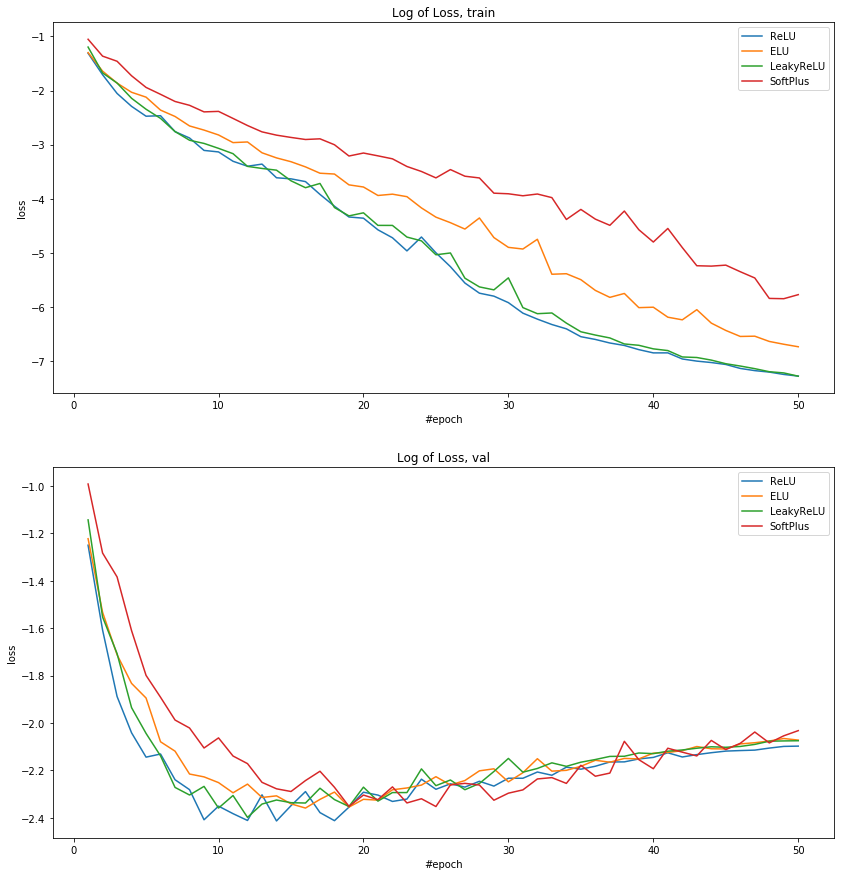

In [125]:
activ_names = ['ReLU', 'ELU', 'LeakyReLU', 'SoftPlus']

plt.figure(figsize=(14, 15))

plt.subplot(2, 1, 1)
plt.title("Log of Loss, train")
plt.xlabel("#epoch")
plt.ylabel("loss")

for i in range(len(activ_names)):
    plt.plot(np.arange(1, len(logs_1[i][0]) + 1), np.log(logs_1[i][0]), label=activ_names[i])
plt.legend() 

plt.subplot(2, 1, 2)
plt.title("Log of Loss, val")
plt.xlabel("#epoch")
plt.ylabel("loss")

for i in range(len(activ_names)):
    plt.plot(np.arange(1, len(logs_1[i][1]) + 1), np.log(logs_1[i][1]), label=activ_names[i])
plt.legend() 

plt.show()

In [127]:
for score, name in zip(scores_1, activ_names):
    print(name + ' test scores:')
    print('Loss: ', score[0])
    print('Accuracy: ', score[1])
    print()

ReLU test scores:
Loss:  0.12459612065689647
Accuracy:  0.9766

ELU test scores:
Loss:  0.12448832524893112
Accuracy:  0.9758

LeakyReLU test scores:
Loss:  0.12521400994245227
Accuracy:  0.974

SoftPlus test scores:
Loss:  0.14353772449841143
Accuracy:  0.9734



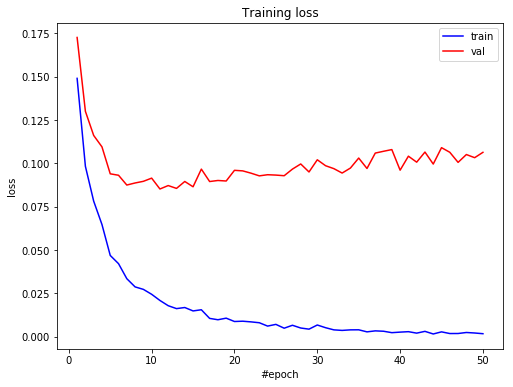

100%|██████████| 50/50 [11:07<00:00, 13.34s/it]

Current loss: 0.106388


In [16]:
logs_2 = []
scores_2 = []
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(28*28, 64))
net.add(ReLU())
net.add(Linear(64, 64))
net.add(ReLU())
net.add(Linear(64, 10))
net.add(LogSoftMax())

log = train_net(net, X_train, y_train, X_val, y_val, criterion=criterion, n_epoch=50, lr=0.01)
logs_2.append(log)
score = compute_score(net, X_test, y_test, criterion=criterion)
scores_2.append(score)

net = Sequential()
net.add(Linear(28*28, 64))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(64))
net.add(ReLU())
net.add(Linear(64, 64))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(64))
net.add(ReLU())
net.add(Linear(64, 10))
net.add(LogSoftMax())

net.train()
log = train_net(net, X_train, y_train, X_val, y_val, criterion=criterion, n_epoch=50, lr=0.01)
logs_2.append(log)
net.evaluate()
score = compute_score(net, X_test, y_test, criterion=criterion)
scores_2.append(score)

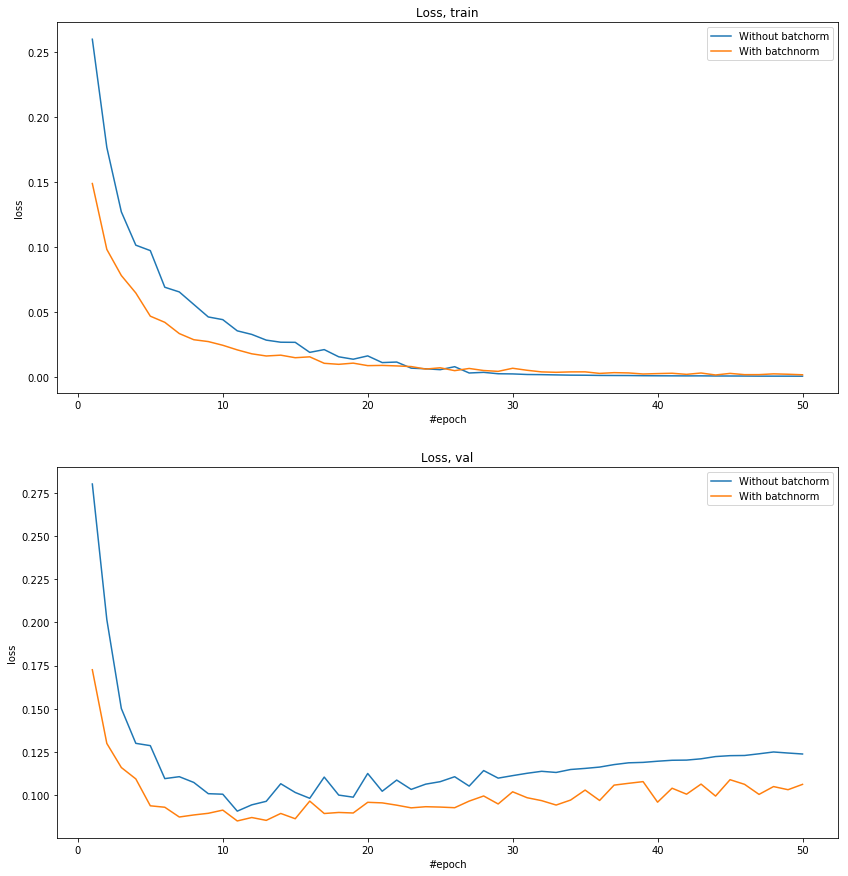

In [17]:
names = ['Without batchorm', 'With batchnorm']
plt.figure(figsize=(14, 15))

plt.subplot(2, 1, 1)
plt.title("Loss, train")
plt.xlabel("#epoch")
plt.ylabel("loss")

for i in range(2):
    plt.plot(np.arange(1, len(logs_2[i][0]) + 1), logs_2[i][0], label=names[i])
plt.legend() 

plt.subplot(2, 1, 2)
plt.title("Loss, val")
plt.xlabel("#epoch")
plt.ylabel("loss")

for i in range(2):
    plt.plot(np.arange(1, len(logs_2[i][1]) + 1), logs_2[i][1], label=names[i])
plt.legend() 

plt.show()

In [18]:
for score, name in zip(scores_2, names):
    print(name + ' test scores:')
    print('Loss: ', score[0])
    print('Accuracy: ', score[1])
    print()

Without batchorm test scores:
Loss:  0.13132776487095038
Accuracy:  0.9764

With batchnorm test scores:
Loss:  0.11285434285995112
Accuracy:  0.9753



Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Из графиков видно, что принципиальных различий в качестве работы различных функций активации нет. Кажется, что лучше всего работает ReLU, а хуже всего — SoftPlus. При этом ReLU является самой простой функцией. Поэтому я бы сказал, что стандартным выбором для функции активации должна стать ReLU. Но если есть подозрение, что может присутствовать проблема умирающих нейронов, то я бы попытался поэкспериментировать с LeakyReLU, потому что она следует за ReLU по своей простоте.

Видно, что батчнорм даёт заметное улучшение функции потерь на валидации. Итоговое значение функции потерь сети с батчнормом лучше, чем у сети без него. С увеличением глубины сети влияние батчнорма на качество должно возрастать. Стоит отметить, что батчнорм заметно замедлил скорость обучения. Поэтому его применение для неглубоких сетей может быть неоправданно.

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [46]:
def train_net_with_decay(net, X_train, y_train, X_val, y_val, criterion,
              n_epoch=20, batch_size=64, lr=0.01, momentum=0.9):
    train_loss_history = []
    val_loss_history = []
    optimizer_config={'learning_rate' : lr, 'momentum': momentum}
    optimizer_state = {}


    for i in trange(n_epoch):
        if i == n_epoch // 2:
            lr /= 5
            
        optimizer_config={'learning_rate' : lr, 'momentum': momentum}
        net.train()
        
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
        
        loss = compute_score(net, X_train, y_train, criterion=criterion)[0]
        train_loss_history.append(loss)
        
        loss = compute_score(net, X_val, y_val, criterion=criterion)[0]
        val_loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#epoch")
        plt.ylabel("loss")
        plt.plot(np.arange(1, len(train_loss_history) + 1), train_loss_history, 'b', label='train')
        plt.plot(np.arange(1, len(val_loss_history) + 1), val_loss_history, 'r', label='val')
        plt.legend()
        plt.show()

        print('Current loss: %f' % loss) 
    
    return train_loss_history, val_loss_history

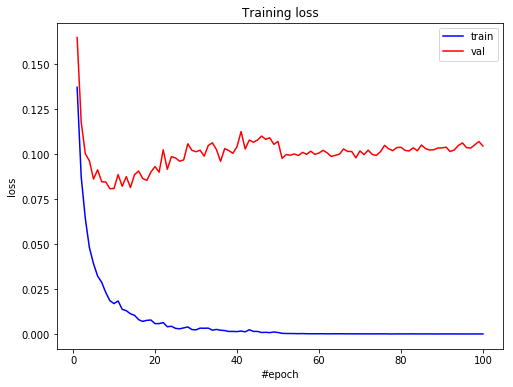

100%|██████████| 100/100 [28:26<00:00, 17.06s/it]

Current loss: 0.104608


In [31]:
logs_3 = []
scores_3 = []
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(28*28, 80))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(80))
net.add(ReLU())
net.add(Linear(80, 80))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(80))
net.add(ReLU())
net.add(Linear(80, 10))
net.add(LogSoftMax())

net.train()
log = train_net_with_decay(net, X_train, y_train, X_val, y_val, criterion=criterion, n_epoch=100, lr=0.01)
logs_3.append(log)
net.evaluate()
score = compute_score(net, X_test, y_test, criterion=criterion)
scores_3.append(score)

Print here your accuracy. It should be around 90%.

In [32]:
print('Test scores:')
print('Loss: ', scores_3[0][0])
print('Accuracy: ', scores_3[0][1])

Test scores:
Loss:  0.10607616278670992
Accuracy:  0.9791


# Autoencoder

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use `MSECriterion` to score the reconstruction. Use `BatchNormalization` (followed by `ChannelwiseScaling` as usual) between `Linear` and `ReLU`. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [16]:
X_train = np.vstack((X_train, X_val))
X_val = X_test

In [29]:
y_train = np.vstack((y_train, y_val))
y_val = y_test

In [51]:
from tqdm import trange

def train_autoencoder(net, X_train, X_val, criterion=MSECriterion(),
                      n_epoch=9, batch_size=256, lr=0.1, momentum=0.9):
    train_loss_history = []
    val_loss_history = []
    optimizer_state = {}
    optimizer_config={'learning_rate' : lr, 'momentum': momentum}

    for i in trange(n_epoch):
        net.train()
        
        for x_batch, y_batch in get_batches((X_train, X_train), batch_size):
            
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
        
        loss = compute_score(net, X_train, X_train, criterion=criterion)[0]
        train_loss_history.append(loss)
        
        loss = compute_score(net, X_val, X_val, criterion=criterion)[0]
        val_loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#epoch")
        plt.ylabel("loss")
        plt.plot(np.arange(1, len(train_loss_history) + 1), train_loss_history, 'b', label='train')
        plt.plot(np.arange(1, len(val_loss_history) + 1), val_loss_history, 'r', label='val')
        plt.legend()
        plt.show()

        print('Current loss: %f' % loss) 
    
    return train_loss_history, val_loss_history

In [116]:
autoencoder = Sequential()

autoencoder.add(Linear(28*28, 512))
autoencoder.add(BatchNormalization(0.9))
autoencoder.add(ChannelwiseScaling(512))
autoencoder.add(ReLU())

autoencoder.add(Linear(512, 256))
autoencoder.add(BatchNormalization(0.9))
autoencoder.add(ChannelwiseScaling(256))
autoencoder.add(ReLU())

autoencoder.add(Linear(256, 128))
autoencoder.add(BatchNormalization(0.9))
autoencoder.add(ChannelwiseScaling(128))
autoencoder.add(ReLU())

autoencoder.add(Linear(128, 30))

autoencoder.add(Linear(30, 128))
autoencoder.add(BatchNormalization(0.9))
autoencoder.add(ChannelwiseScaling(128))
autoencoder.add(ReLU())

autoencoder.add(Linear(128, 256))
autoencoder.add(BatchNormalization(0.9))
autoencoder.add(ChannelwiseScaling(256))
autoencoder.add(ReLU())

autoencoder.add(Linear(256, 512))
autoencoder.add(BatchNormalization(0.9))
autoencoder.add(ChannelwiseScaling(512))
autoencoder.add(ReLU())

autoencoder.add(Linear(512, 28*28))

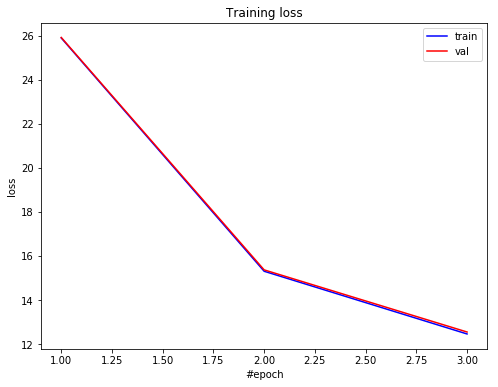

100%|██████████| 3/3 [39:04<00:00, 781.37s/it]

Current loss: 12.545208


In [117]:
logs_auto = []
log = train_autoencoder(autoencoder, X_train, X_val, n_epoch=3, lr=0.01, batch_size=128)
logs_auto.append(log)

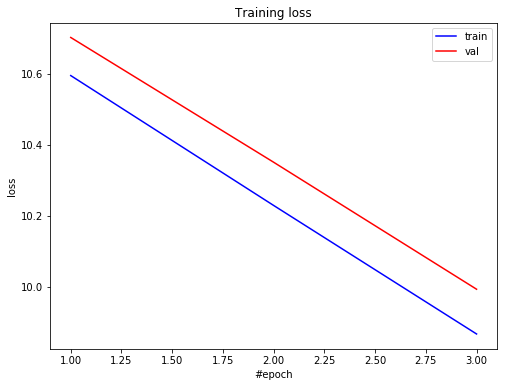

100%|██████████| 3/3 [38:41<00:00, 773.81s/it]

Current loss: 9.992954


In [118]:
log = train_autoencoder(autoencoder, X_train, X_val, n_epoch=3, lr=0.01 / 2, batch_size=128)
logs_auto.append(log)

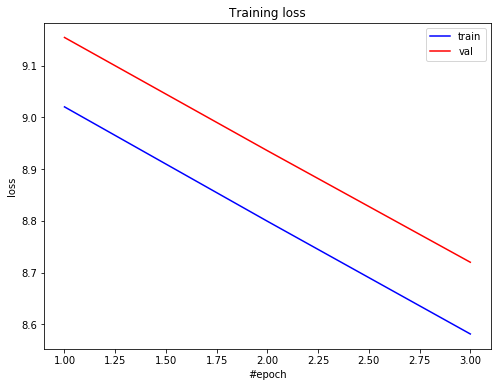

100%|██████████| 3/3 [38:21<00:00, 767.13s/it]

Current loss: 8.720201


In [119]:
log = train_autoencoder(autoencoder, X_train, X_val, n_epoch=3, lr=0.01 / 3, batch_size=128)
logs_auto.append(log)

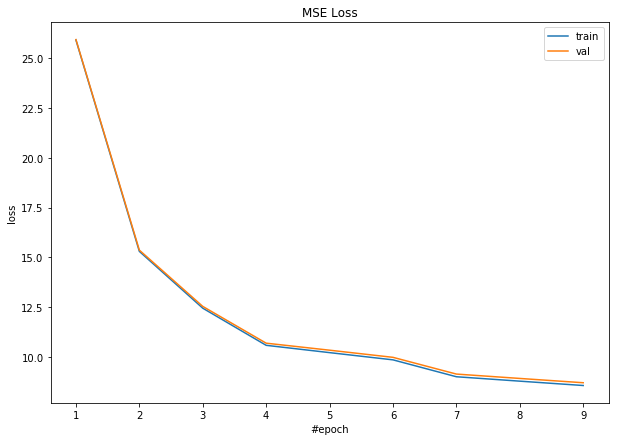

In [131]:
plt.figure(figsize=(10, 7))
plt.title("MSE Loss")
plt.xlabel("#epoch")
plt.ylabel("loss")

plt.plot(np.arange(1, 10), logs_auto[0][0] + logs_auto[1][0] + logs_auto[2][0], label='train')
plt.plot(np.arange(1, 10), logs_auto[0][1] + logs_auto[1][1] + logs_auto[2][1], label='val')
plt.legend() 
plt.show()

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [132]:
from copy import deepcopy
encoder = deepcopy(autoencoder)

# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

for i in range(13):
    encoder.remove()
X_train_inn = encoder.forward(X_train)
X_val_inn = encoder.forward(X_val)

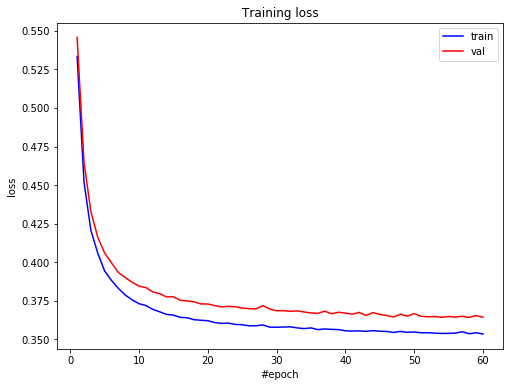

100%|██████████| 60/60 [01:03<00:00,  1.05s/it]

Current loss: 0.364392


In [134]:
# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 10))
cnet.add(LogSoftMax())

# Learn the weights
# Your code goes here. ################################################
criterion = ClassNLLCriterion()
_ = train_net(cnet, X_train_inn, y_train, X_val_inn, y_val, criterion=criterion, n_epoch=60, lr=0.01)

In [136]:
# And add learned layers ontop.
encoder.add(cnet[0])
encoder.add(cnet[1])

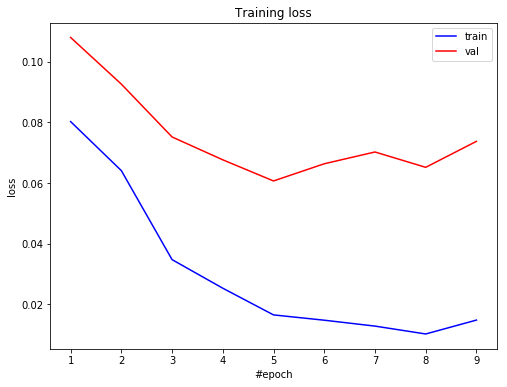

100%|██████████| 9/9 [18:19<00:00, 122.12s/it]

Current loss: 0.073777


([0.08028954142509434,
  0.06412115290824724,
  0.03476414315501777,
  0.025337293193003794,
  0.016533877433910986,
  0.014787306010188378,
  0.012843037957617078,
  0.010246496768317511,
  0.014828258288307937],
 [0.10803774261192935,
  0.09265138217989291,
  0.0752209614908155,
  0.06768328384271831,
  0.06071389579068634,
  0.06638355157549983,
  0.0702679601054991,
  0.06521019967199275,
  0.07377727854754929])

In [137]:
# Now optimize whole model
# Your code goes here. ################################################
train_net(encoder, X_train, y_train, X_val, y_val, criterion=criterion, n_epoch=9, lr=0.01)

In [141]:
score = compute_score(encoder, X_val, y_val, criterion=criterion)

In [142]:
print('Test scores:')
print('Loss: ', score[0])
print('Accuracy: ', score[1])

Test scores:
Loss:  0.07377727854754929
Accuracy:  0.9807000000000001


* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Данный метод дал немного лучшие результаты, чем прямое обучение нейросети. Я думаю, что в реальности такой способ примменять не стоит. Раньше его применяли, потому что люди не умели обучать глубокие нейросети, а сейчас же ситуация поменялась.

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [143]:
from sklearn.decomposition import PCA

In [144]:
pca = PCA(n_components=30)
pca.fit(X_train)
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

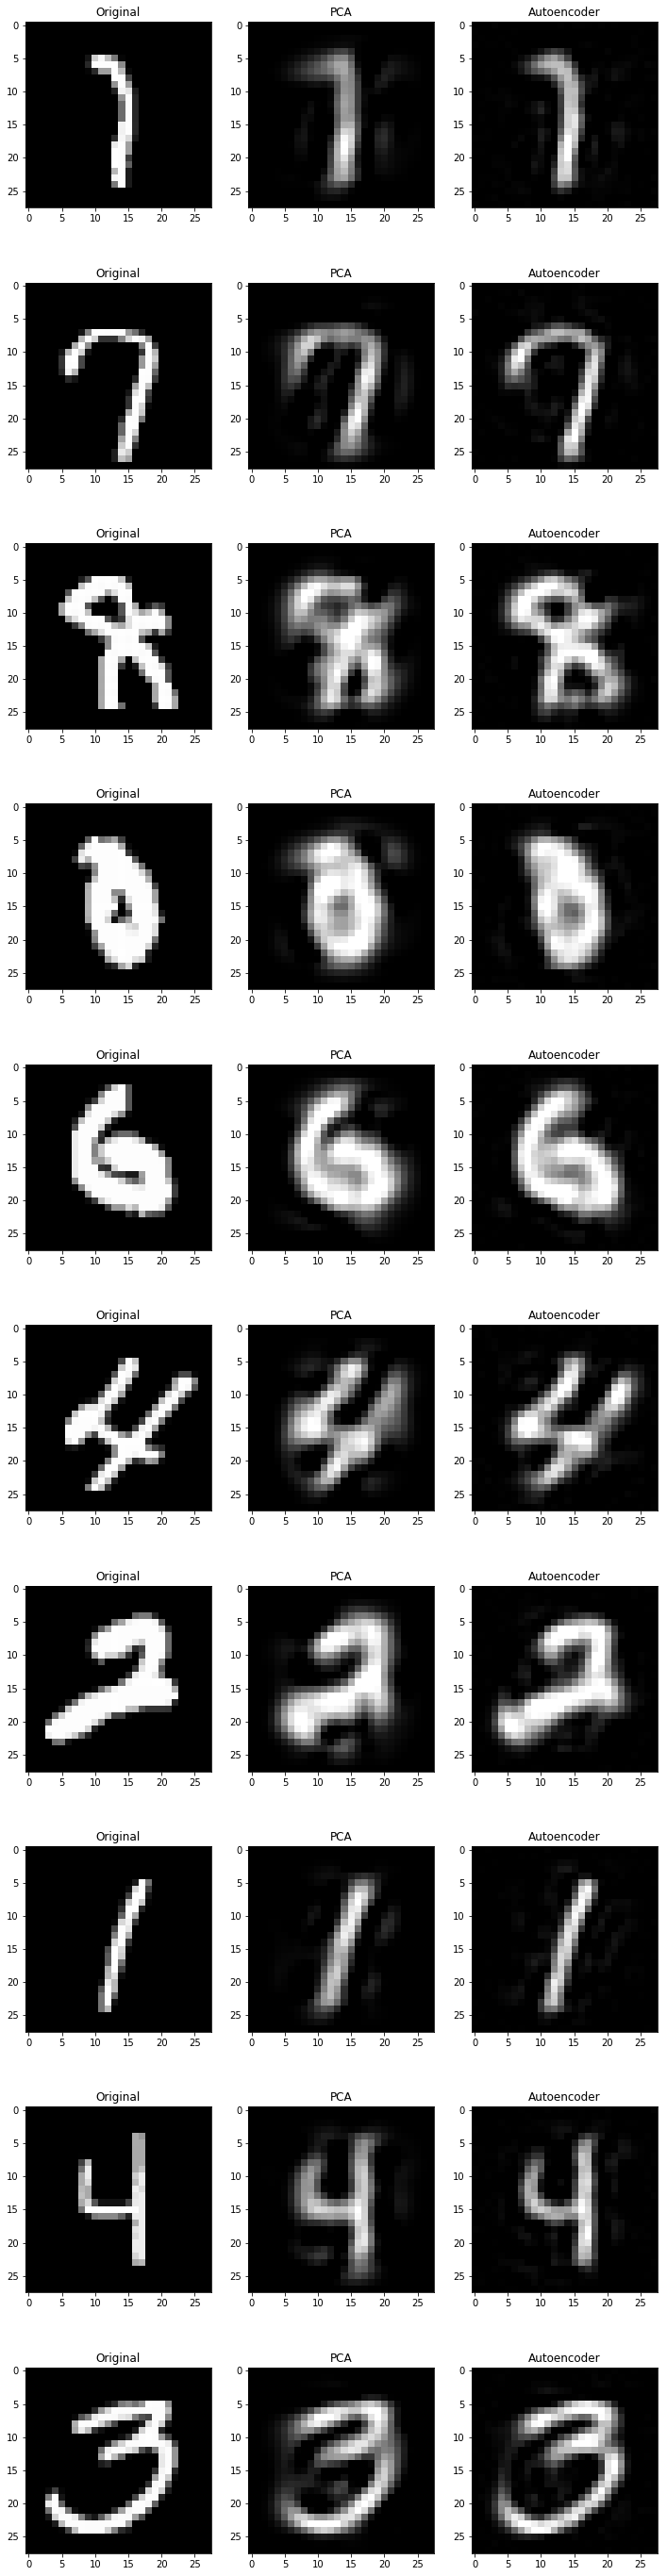

In [146]:
num = 10
images_idx = np.random.choice(np.arange(len(X_val)), replace=False, size=num)

plt.figure(figsize=(12, 5 * num))
for i, idx in zip(np.arange(num), images_idx):
    plt.subplot(num, 3, 3*i + 1)
    plt.title('Original')
    plt.imshow(X_val[idx].reshape(28, -1), cmap='gray')
    plt.subplot(num, 3, 3*i + 2)
    plt.title('PCA')
    plt.imshow(np.clip(pca.inverse_transform(pca.transform(X_val[idx][None, :]))[0], 0, 1).reshape(28, -1), cmap='gray')
    plt.subplot(num, 3, 3*i + 3)
    plt.title('Autoencoder')
    plt.imshow(np.clip(autoencoder.forward(X_val[idx][None, :])[0], 0, 1).reshape(28, -1), cmap='gray')

Видно, что автоэнкодер даёт более чёткую картинку, чем PCA.